In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from qiskit.quantum_info import Statevector, partial_trace
import os
import sys
from qiskit import transpile
from data import load_01
import autograd.numpy as anp
from scipy.optimize import minimize
from sklearn.metrics import log_loss
sys.path.append('..')
from q_alchemy.qiskit import QAlchemyInitialize

os.environ["Q_ALCHEMY_API_KEY"] = "n6I5ypSXJeb8E1mlX71gAJ1v9RCKSb52"

algorithm_globals.random_seed = 12345

## SU4 convolutional layer

In [5]:
# We now define a convolutional layer with SU4 gate
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.u(params[0], params[1], params[2], 0)
    target.u(params[3], params[4], params[5], 1)
    target.cx(0, 1)
    target.ry(params[6], 0)
    target.rz(params[7], 1)
    target.cx(1, 0)
    target.ry(params[8], 0)
    target.cx(0, 1)
    target.u(params[9], params[10], params[11], 0)
    target.u(params[12], params[13], params[14], 1)
    return target


[0.06292042 0.85667505 0.72315218 0.40585159 0.59208271 0.84930548
 0.54077574 0.51458966 0.21354378 0.02865273 0.82937943 0.14016008
 0.39286318 0.27649883 0.72000807]


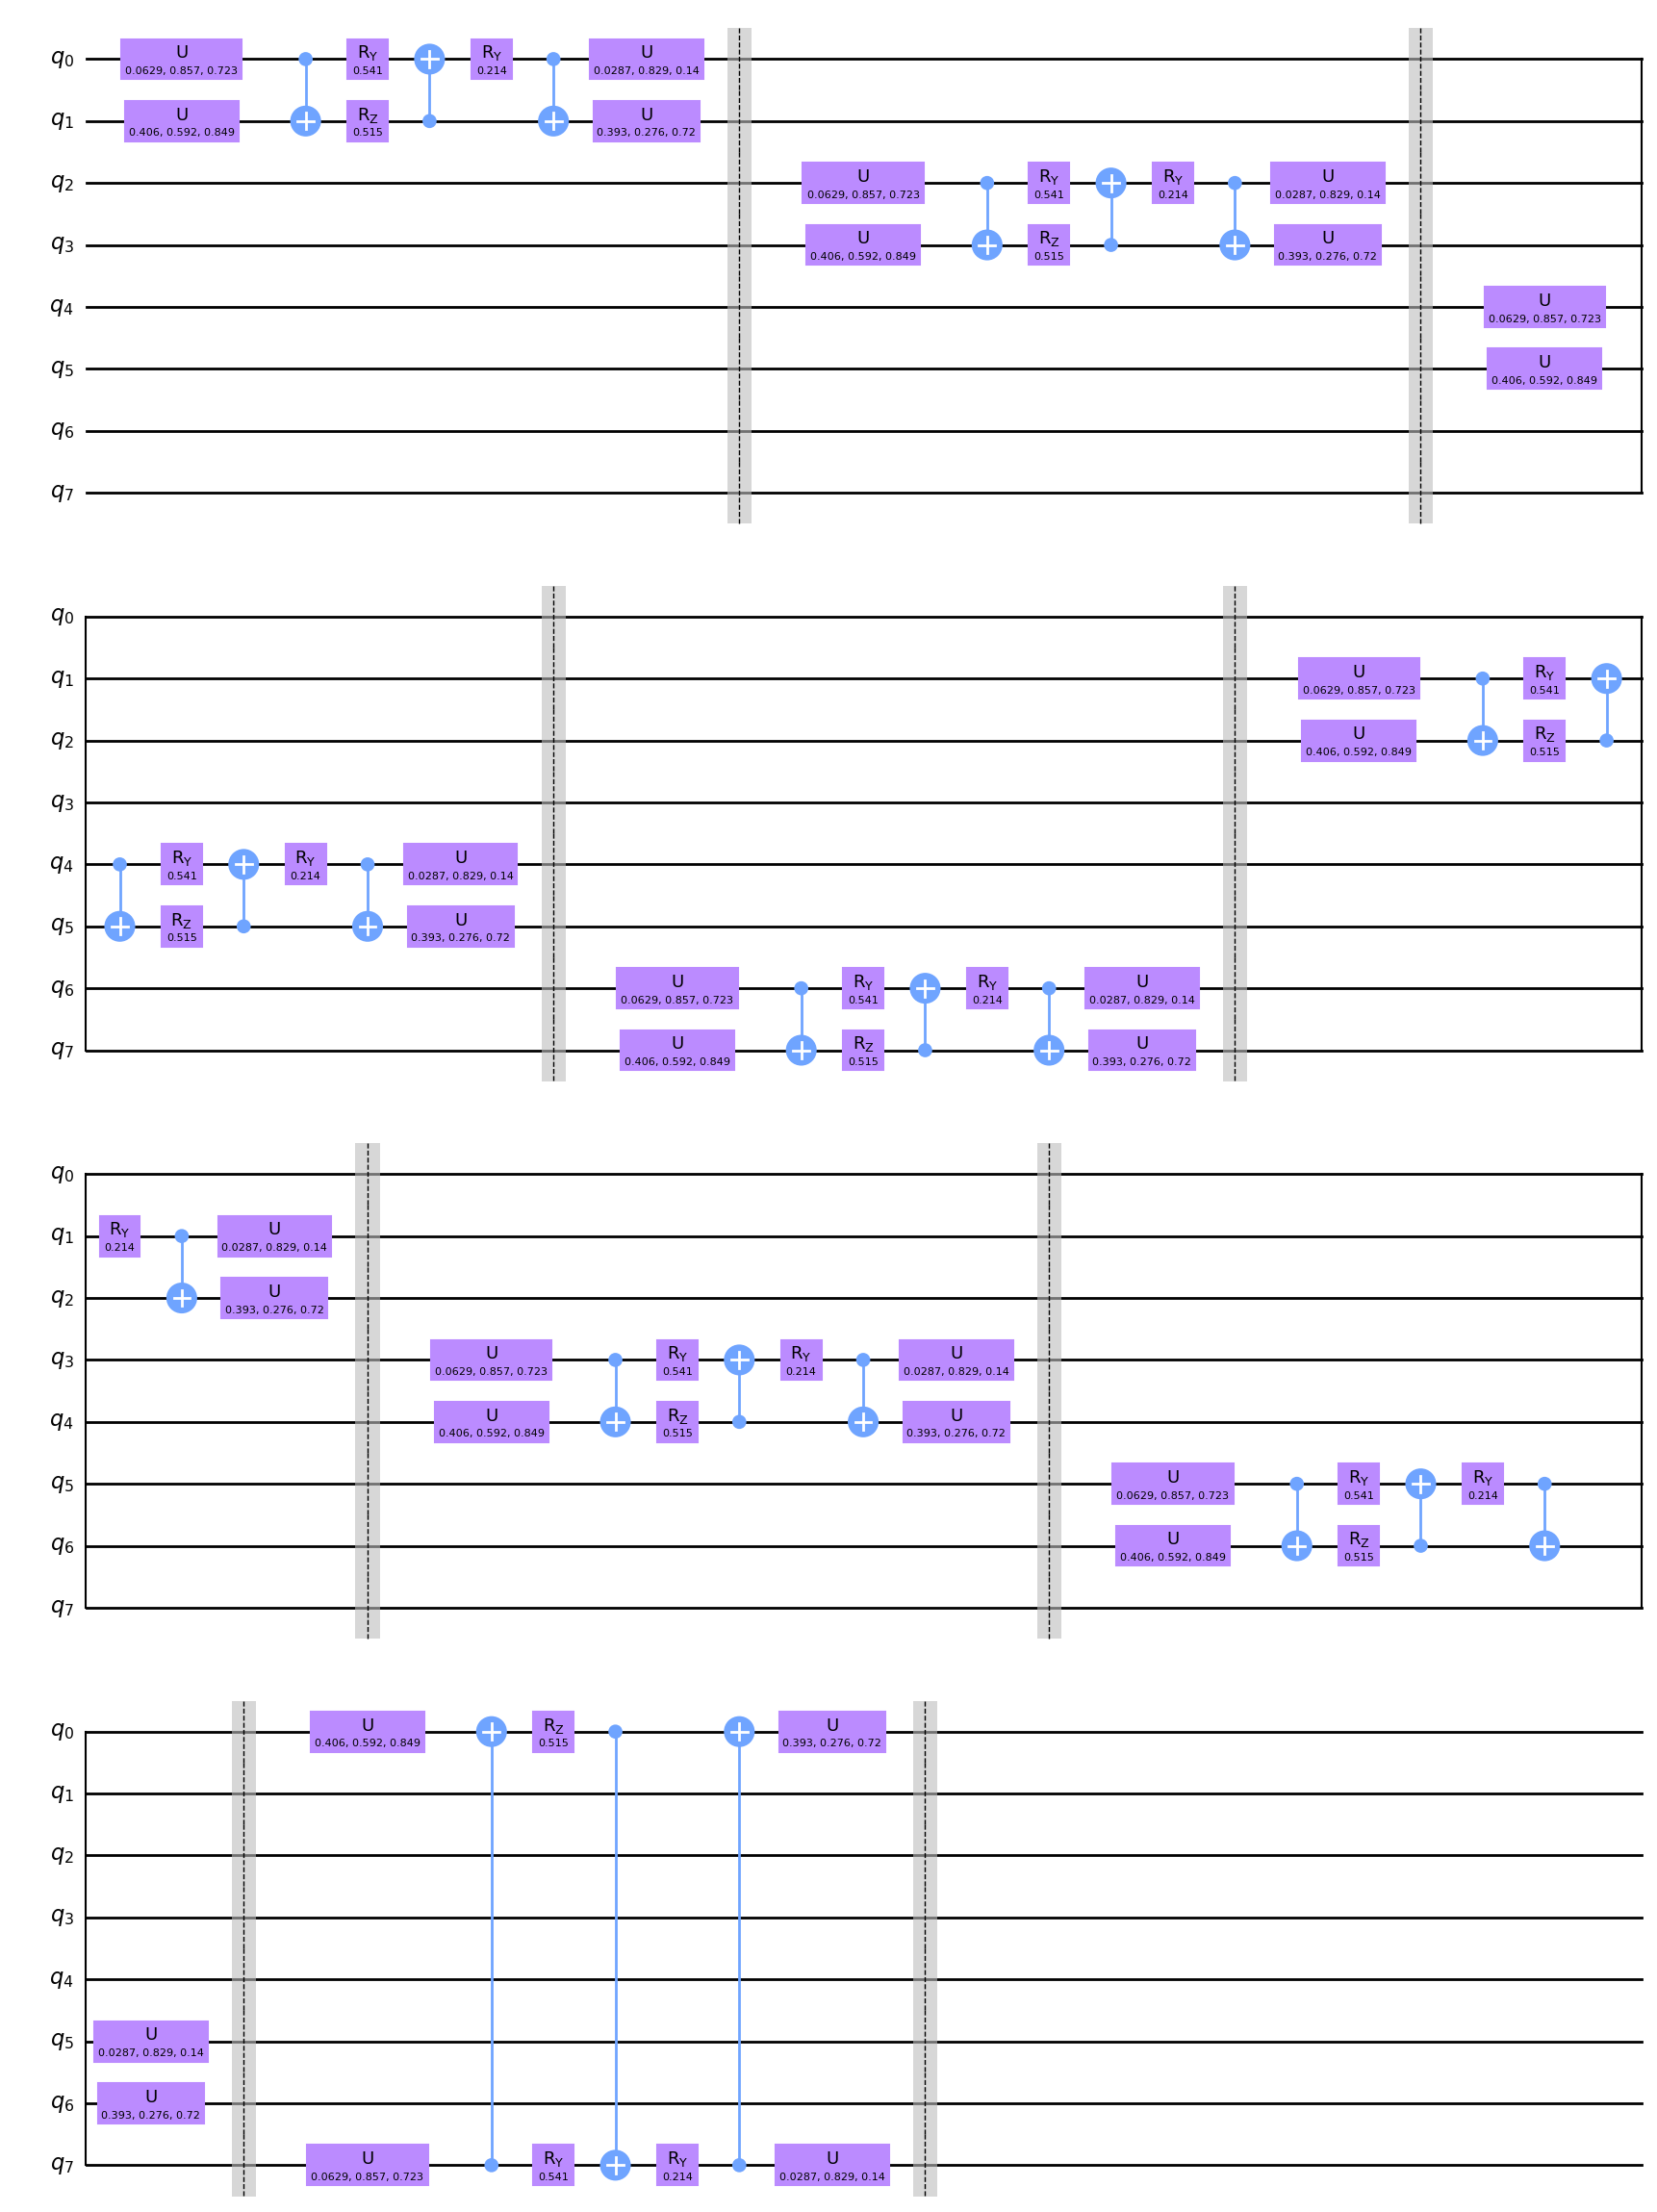

In [6]:
def conv_layer(num_qubits, params):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params), [q1, q2])
        qc.barrier()
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

params = np.random.rand(15)
print(params)
circuit = conv_layer(8, params)
circuit.decompose().draw("mpl")


In [7]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.crz(params[0], 0, 1)
    target.x(0)
    target.crx(params[1], 0, 1)
    return target

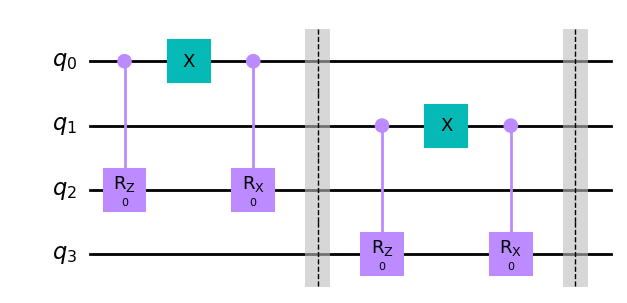

In [8]:
def pool_layer(sources, sinks, params):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
params = [0, 0]
circuit = pool_layer(sources, sinks, params)
circuit.decompose().draw("mpl")

In [9]:
import tensorflow as tf
def load_minist01():
    classes = [0, 1]
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
    
    x_train_filter_01 = np.where((y_train == classes[0]) | (y_train == classes[1]))
    x_test_filter_01 = np.where((y_test == classes[0]) | (y_test == classes[1]))

    X_train, X_test = x_train[x_train_filter_01], x_test[x_test_filter_01]
    Y_train, Y_test = y_train[x_train_filter_01], y_test[x_test_filter_01]
    
    Y_train = [1 if y == classes[0] else -1 for y in Y_train]
    Y_test = [1 if y == classes[0] else -1 for y in Y_test]
    
    X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
    X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
    X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()
    
    X_train_norms, X_test_norms = np.linalg.norm(X_train, axis=1), np.linalg.norm(X_test, axis=1)
    X_train_norms, X_test_norms = X_train_norms[:, np.newaxis], X_test_norms[:, np.newaxis]
    
    X_train, X_test = X_train/X_train_norms, X_test/X_test_norms
    
    return X_train, X_test, Y_train, Y_test

In [10]:
X_train, X_test, y_train, y_test = load_minist01()

In [11]:
def construct_conv_pool(params):
    ansatz = QuantumCircuit(8, name="Ansatz")
    ansatz.compose(conv_layer(8, params[0:15]), list(range(8)), inplace=True)
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], params[15:17]), list(range(8)), inplace=True)
    
    ansatz.compose(conv_layer(4, params[17:32]), list(range(4, 8)), inplace=True)
    ansatz.compose(pool_layer([0, 1], [2, 3], params[32:34]), list(range(4, 8)), inplace=True)
    
    ansatz.compose(conv_layer(2, params[34:49]), list(range(6, 8)), inplace=True)
    ansatz.compose(pool_layer([0], [1], params[49:51]), list(range(6, 8)), inplace=True)
    return ansatz

    

In [12]:
def preparation_circuit(X):
    sp_org = QAlchemyInitialize(X, opt_params={'max_fidelity_loss':0.0})
    qc_final = QuantumCircuit(sp_org.definition.num_qubits, name="preparation")
    qc = transpile(sp_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    qc_inst = qc.to_instruction()
    qc_final.append(qc_inst, range(sp_org.definition.num_qubits))
    return qc_final

In [13]:
def construct_full_circuit(X, params):
    qc = QuantumCircuit(8, 8)
    
    embedding = preparation_circuit(X)
    conv_and_pool = construct_conv_pool(params)
    
    qc.compose(embedding, list(range(8)),inplace=True)
    qc.compose(conv_and_pool, list(range(8)),inplace=True)
    
    return qc
    

/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


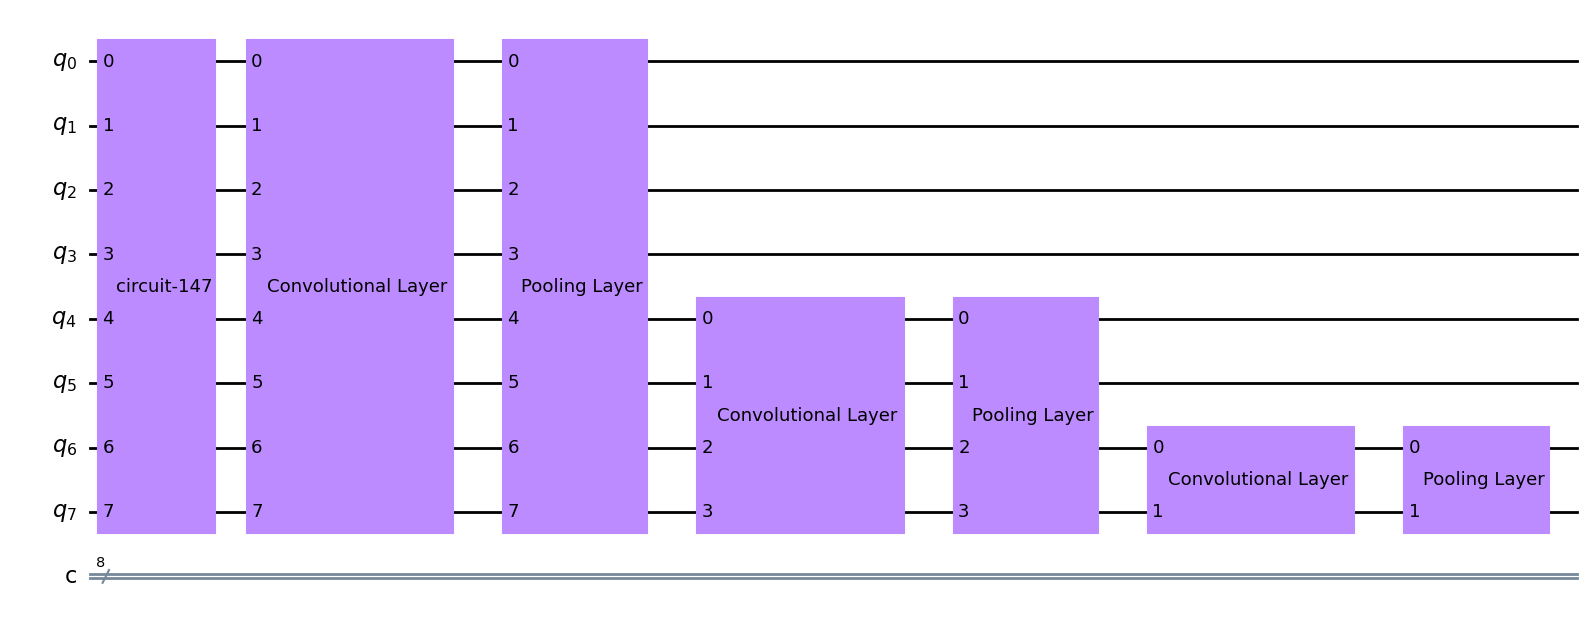

In [14]:
params = np.random.rand(51)
qc = construct_full_circuit(X_train[0], params)
qc.draw("mpl")


In [15]:
def predicted_label(qc):
    full_statevector = Statevector(qc)
    partial_density_matrix = partial_trace(full_statevector, list(range(7)))
    partial_statevector = np.diagonal(partial_density_matrix)
    
    if partial_statevector[0] > partial_statevector[1]:
        label = 1
    else:
        label = -1
        
    return label

## Training QCNN

In [18]:
label = predicted_label(qc)
print(label)
print(y_train[0])

1
1


In [19]:
def cost(params, X, Y):
    predictions = []
    for x in X:
        qc = construct_full_circuit(x, params)
        predictions.append(predicted_label(qc))
        
    loss = log_loss(Y, predictions)
    return loss


In [20]:
def circuit_training(X_train, Y_train, steps, batch_size):

    initial_params = np.random.randn(51)
    
    batch_results = []

    for it in range(steps):
        print(f"starting iteration {it}")
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        result = minimize(
                    lambda params: cost(params, X_batch, Y_batch),
                    initial_params,
                    method='COBYLA'  # You can choose a different optimization method
                )
        updated_params = result.x
        batch_cost = result.fun
        
        batch_results.append({'batch': it, 'params': updated_params, 'cost': batch_cost})

        
        #if it % 10 == 0:
        print("iteration: ", it, " cost: ", batch_cost)
    return batch_results

In [21]:
batch_results = circuit_training(X_train[:100], y_train[:100], 200, 2)

starting iteration 0


/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anacond

: 

: 